<a href="https://colab.research.google.com/github/SG7504/ML-Driven-EEG-Insights/blob/main/LGBM(FINAL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter the number of nodes for the LGBM Classifier: 5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 3876, number of used features: 4
[LightGBM] [Info] Start training from score -0.922372
[LightGBM] [Info] Start training from score -1.111858
[LightGBM] [Info] Start training from score -1.296535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

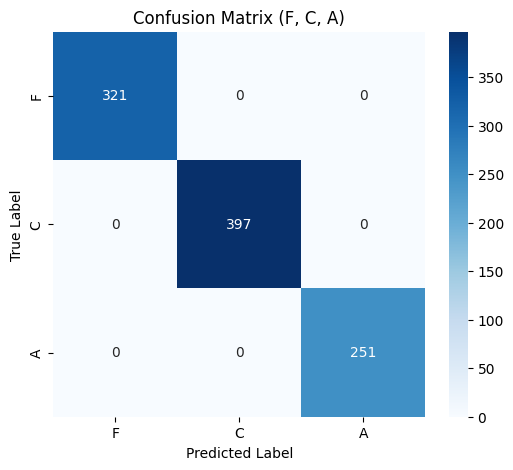

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


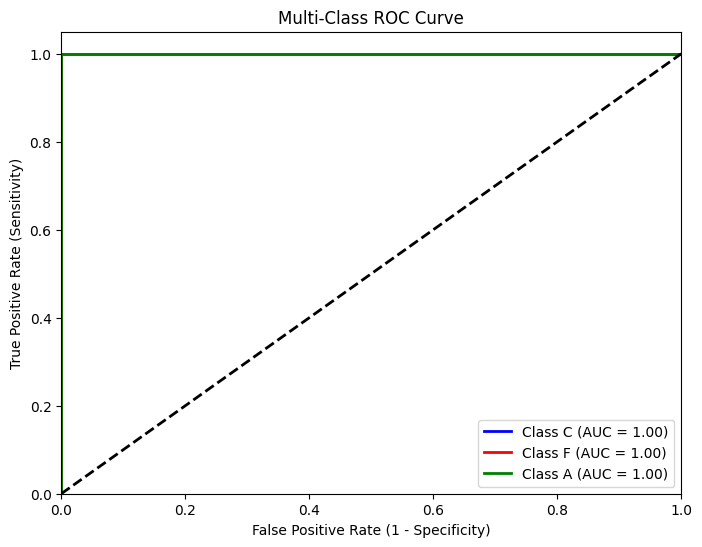

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    cohen_kappa_score, roc_curve, auc
)
import lightgbm as lgb
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
file_path = "/content/drive/My Drive/EEG/final_data2.csv"
df = pd.read_csv(file_path)

# Label Encoding
class_labels = ['C', 'F', 'A']  # Define class order
label_encoders = {}
for col in ['Channel', 'Band', 'participant_id', 'Group']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Features and Target
X = df[['Channel', 'Band', 'Dominant Frequency (Hz)', 'participant_id']]
y = df['Group']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Manual Input for Number of Nodes
num_nodes = int(input("Enter the number of nodes for the LGBM Classifier: "))

def train_and_evaluate(num_nodes):
    # Train LightGBM Classifier
    lgbm = lgb.LGBMClassifier(num_leaves=num_nodes, random_state=42)
    lgbm.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = lgbm.predict(X_train_scaled)
    y_test_pred = lgbm.predict(X_test_scaled)

    # Model Evaluation
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred, labels=[1, 0, 2])  # F, C, A order
    kappa = cohen_kappa_score(y_test, y_test_pred)
    report = classification_report(y_test, y_test_pred, output_dict=True)

    # Compute Specificity, FDR, and other metrics
    ppv_scores, npv_scores, fdr_scores, specificity_scores = [], [], [], []
    for i in range(len(class_labels)):
        tp = conf_matrix[i, i]
        fp = sum(conf_matrix[:, i]) - tp
        fn = sum(conf_matrix[i, :]) - tp
        tn = conf_matrix.sum() - (tp + fp + fn)

        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        ppv_scores.append(ppv)
        npv_scores.append(npv)
        fdr_scores.append(fdr)
        specificity_scores.append(specificity)

    mean_ppv = np.mean(ppv_scores)
    mean_npv = np.mean(npv_scores)
    mean_fdr = np.mean(fdr_scores)
    mean_specificity = np.mean(specificity_scores)

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {test_accuracy:.4f}")
    print(f"Kappa Score: {kappa:.4f}")
    print(f"Specificity: {mean_specificity:.4f}")
    print(f"FDR: {mean_fdr:.4f}")

    # Print Class-wise Metrics
    print("\n### Class-wise Performance Metrics ###")
    print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Support':<10}")
    print("-" * 50)
    for class_label, i in zip(class_labels, range(len(class_labels))):
        precision = report[str(i)]['precision']
        recall = report[str(i)]['recall']
        f1_score = report[str(i)]['f1-score']
        support = report[str(i)]['support']
        print(f"{class_label:<10} {precision:<10.4f} {recall:<10.4f} {f1_score:<10.4f} {support:<10.0f}")

    # Confusion Matrix Heatmap (F, C, A order)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['F', 'C', 'A'], yticklabels=['F', 'C', 'A'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (F, C, A)')
    plt.show()

    # Multi-Class ROC Curve (C, F, A original order)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # C, F, A original order
    y_score = lgbm.predict_proba(X_test_scaled)
    n_classes = y_test_bin.shape[1]

    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'red', 'green'])

    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    # Baseline diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Train model with user input nodes
train_and_evaluate(num_nodes)
